# Imports

In [17]:
%%time
#Imports requisite packages
import os
import time
import numpy
import pickle
import cProfile
import itertools
import matplotlib
import sklearn.tree
import sklearn.metrics
import sklearn.ensemble
import sklearn.preprocessing
import sklearn.learning_curve
import sklearn.model_selection
import sklearn.cross_validation
import sklearn.feature_selection
import sklearn.kernel_approximation
from matplotlib import pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.cross_validation import *
from sklearn.metrics import *
from sklearn.feature_selection import *
from sklearn.preprocessing import *
from sklearn.svm import *


#%jsroot on9
%matplotlib inline
matplotlib.use('Agg')

CPU times: user 2.52 ms, sys: 1.12 ms, total: 3.64 ms
Wall time: 2.83 ms


/Users/fsiroky/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Function Definitions

In [ ]:
# print(array)

In [18]:
%%time
#Takes the converted tree and turns it into an
#n-by-30 array usable by sklearn.
def outputs(array):
    #Only uses events with non-zero luminosity
    goodEvents = array[array['lumi'] != 0]
    ind = numpy.lexsort((goodEvents['lumiId'],goodEvents['runId']))
    events = goodEvents[ind]
    dataset = numpy.empty([len(goodEvents),30])
    target = numpy.empty([len(goodEvents)])
    badOnes = numpy.array([])

    #Fills dataset array with proper features
    for j, event in enumerate(events):
        try:
            dataset[j,0:7] = event['qPFJetPt']
            dataset[j,7:14] = event['qPFJetEta']
            dataset[j,14:21] = event['qPFJetPhi']
            dataset[j,21:28] = event['qNVtx']
            dataset[j,28] = event['crossSection']
            dataset[j,29] = event['lumi']
            target[j] = event['isSig']
        except ValueError:
            badOnes = numpy.append(badOnes,j)
            
    #Takes out corrupt events
    mask = numpy.zeros(len(dataset), dtype=bool)
    mask[badOnes.astype(int)] = True
    mask = ~mask
    dataset = dataset[mask]
    target = target[mask]
       
    return dataset, target

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


In [19]:
#Function that plots confusion matrix, taken from sklearn website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    #This function prints and plots the confusion matrix.
    #Normalization can be applied by setting `normalize=True`.     
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = numpy.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        print("Normalized confusion matrix")
    else:
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = numpy.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        print('Confusion matrix, without normalization')

    print(cm)
    
    thresh = cm.max()*.7
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Data Prep

In [20]:
#Loads pickled dataset
inFile = open('dataWithMet.pkl', 'rb')
dataset = pickle.load(inFile, encoding="latin1")
target = pickle.load(inFile, encoding="latin1")
inFile.close()

inFile = open('jetMetTarget.pkl', 'rb')
target = pickle.load(inFile, encoding="latin1")
inFile.close()

In [21]:
print(dataset)

[[  3.87361717e+01   4.99334755e+01   1.00006313e+01 ...,   2.10000000e+01
    3.40000000e+01   3.62249969e+05]
 [  3.95219574e+01   5.13442535e+01   1.00004625e+01 ...,   2.10000000e+01
    3.70000000e+01   3.51249969e+05]
 [  3.92135391e+01   5.05862350e+01   1.00001659e+01 ...,   2.10000000e+01
    3.60000000e+01   3.41999969e+05]
 ..., 
 [  6.44936066e+01   1.00514908e+02   1.00001659e+01 ...,   1.70000000e+01
    3.20000000e+01   1.63971621e+04]
 [  6.47788010e+01   1.03021576e+02   1.00001974e+01 ...,   1.70000000e+01
    2.90000000e+01   1.59858154e+04]
 [  6.56554260e+01   1.02939850e+02   1.00004864e+01 ...,   1.70000000e+01
    2.90000000e+01   1.57304961e+04]]


In [22]:
# count1 = 0
# count2 = 0
# for j in range(0,len(target)):
#     if target[j] == False:
#         count1 = count1 + 1
#     if targetz[j] == False:
#         count2=count2 +1
# print(count1)
# print(count2)
# print(count2-count1)
# lumi = dataset[:,-1]
# dataset = dataset[:,:-1]
print(len(target))
print(len(dataset))
sigInd = numpy.where(target==1)
backInd = numpy.where(target==0)
sigVals = dataset[sigInd]
backVals = dataset[backInd]
sigTarget = target[sigInd]
backTarget = target[backInd]

sigTrain, sigTest, sigTrainTarget, sigTestTarget = train_test_split(sigVals, sigTarget, test_size=.2, random_state=42)
# lumiTrain = sigTrain[:,-1]
# sigTrain = sigTrain[:,:-1]
# sigTest = sigTest[:,:-1]

232438
232438


In [23]:
# #Imports training and testing sets used across models
# inFile = open('splits.pkl', 'rb')
# xTrain = pickle.load(inFile, encoding="latin1")
# xTest = pickle.load(inFile, encoding="latin1")
# yTrain = pickle.load(inFile, encoding="latin1")
# yTest = pickle.load(inFile, encoding="latin1")
# lumiTrain = pickle.load(inFile, encoding="latin1")
# lumiTest = pickle.load(inFile, encoding="latin1")
# inFile.close()

In [24]:
# # #Removes features with variance less than 0.1
# sel = VarianceThreshold(threshold = 0.1)
# print(sigTrain.shape)
# sel.fit(sigTrain)
# indices = sel.get_support()
# sigTrain = sigTrain[:,indices]
# print(sigTrain.shape)
# sigTest = sigTest[:,indices]
# print(indices)
# backVals = backVals[:,indices]

In [25]:
# #Scales the data to zero mean and unit variance
scaler = StandardScaler()
scaler.fit(sigTrain)
sigTrain = scaler.transform(sigTrain)
sigTest = scaler.transform(sigTest)
backVals = scaler.transform(backVals)
backTarget[backTarget == 0] = -1
# sigTrainTarget[sigTrainTarget == 0] = -1
# sigTestTarget[sigTestTarget == 0] = -1
# print(len(sigTestTarget[sigTestTarget==-1]))
# print(len(sigTrainTarget[sigTrainTarget==1]))

In [26]:
%%time
nuVal = 0.02
gammaVal = "auto"
osvmClf = OneClassSVM(nu=nuVal, gamma=gammaVal)
osvmClf.fit(sigTrain)

CPU times: user 3min 19s, sys: 4.07 s, total: 3min 23s
Wall time: 3min 24s


In [27]:
y_pred_train = osvmClf.predict(sigTrain)
y_pred_test = osvmClf.predict(sigTest)
y_pred_outliers = osvmClf.predict(backVals)

# falsePositives = y_pred_outlieers[y]

In [28]:
falseNegTrain = y_pred_train[y_pred_train == -1].size
falseNegTest = y_pred_test[y_pred_test == -1].size
falsePos = y_pred_outliers[y_pred_outliers == 1].size
truePosTrain = y_pred_train[y_pred_train == 1].size
truePosTest = y_pred_test[y_pred_test == 1].size

In [29]:
# %%time
# #Provides classification reports 
# osvmScore = osvmClf.fit(sigTrain).decision_function(sigTest)
    
# osvmPredict = osvmClf.predict(sigTest)
# print("Classification report for osvm, Tuned, Weights %s:\n%s\n"
#       % (osvmClf, sklearn.metrics.classification_report(sigTestTarget, osvmPredict)))
print(y_pred_train)
print(y_pred_test)
print(y_pred_outliers)

print(falseNegTest)

[ 1.  1.  1. ...,  1.  1.  1.]
[ 1.  1.  1. ...,  1.  1.  1.]
[-1.  1.  1. ..., -1. -1. -1.]
953


In [30]:
# %%time
#Plots classification results for signal and background
osvmArrs = []
osvmHists = []

#Separates decision function results into signal and background
#along with training and testing
osvmArrs.append(osvmClf.decision_function(sigTrain).ravel())
osvmArrs.append(osvmClf.decision_function(sigTest).ravel())
osvmArrs.append(osvmClf.decision_function(backVals).ravel())

Loss Rate                                           :  2.0795147071659246
Pollution Rate                                      :  2.867965367965368
Number of errors on training set :  3668  Percentage:  2.000960111722091
Number of errors on test set     :  953  Percentage:  2.0795147071659246
Number of errors on outliers set :  1325  Percentage:  40.17586416009703


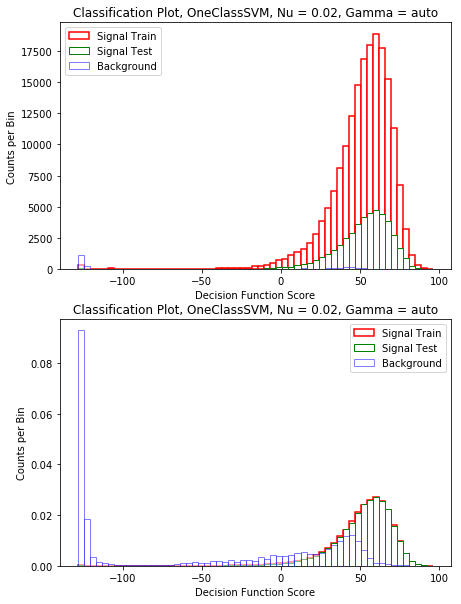

In [31]:
plotMin = min(min(osvmArrs[0]), min(osvmArrs[1]), min(osvmArrs[2]))
plotMax = max(max(osvmArrs[0]), max(osvmArrs[1]), max(osvmArrs[2]))
binz = numpy.linspace(plotMin, plotMax, 60)

plt.figure(figsize=(7, 10))
plt.subplot(211)
plt.hist(osvmArrs[0], normed = False, bins = binz, edgecolor = 'red',   
         facecolor = 'white', alpha=1, label = "Signal Train", linewidth = 1.5)
plt.hist(osvmArrs[1], normed = False, bins = binz, edgecolor = 'green', 
         facecolor = 'white', alpha=1, label = "Signal Test")
plt.hist(osvmArrs[2], normed = False, bins = binz, edgecolor = 'blue',  
         facecolor = 'white', alpha=0.5, label = "Background")
plt.title("Classification Plot, OneClassSVM, Nu = %s, Gamma = %s" % (nuVal, gammaVal))
plt.xlabel("Decision Function Score")
plt.ylabel("Counts per Bin")
plt.legend()

plt.subplot(212)
plt.hist(osvmArrs[0], normed = True, bins = binz, edgecolor = 'red',   
         facecolor = 'white', alpha=1, label = "Signal Train", linewidth = 1.5)
plt.hist(osvmArrs[1], normed = True, bins = binz, edgecolor = 'green', 
         facecolor = 'white', alpha=1, label = "Signal Test")
plt.hist(osvmArrs[2], normed = True, bins = binz, edgecolor = 'blue',  
         facecolor = 'white', alpha=0.5, label = "Background")
plt.title("Classification Plot, OneClassSVM, Nu = %s, Gamma = %s" % (nuVal, gammaVal))
plt.xlabel("Decision Function Score")
plt.ylabel("Counts per Bin")
plt.legend()

print("Loss Rate                                           : ", (falseNegTest/(truePosTest+falseNegTest)*100))
print("Pollution Rate                                      : ", (falsePos/(truePosTest+falsePos))*100)
print("Number of errors on training set : ", falseNegTrain, " Percentage: ", (falseNegTrain/len(sigTrain)*100))
print("Number of errors on test set     : ", falseNegTest, " Percentage: ", (falseNegTest/len(sigTest)*100))
print("Number of errors on outliers set : ", falsePos, " Percentage: ", (falsePos/len(backVals)*100))


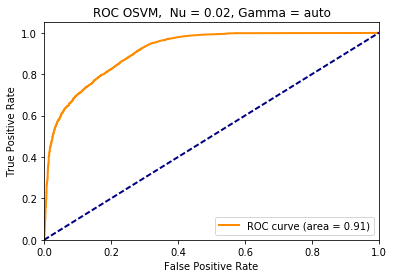

In [32]:
yTest = numpy.append(sigTestTarget, backTarget)
osvmScore = numpy.append(osvmArrs[1], osvmArrs[2])
fpr, tpr, _ = roc_curve(yTest, osvmScore)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2;
plt.plot(fpr, tpr, color='darkorange',
        lw = lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw = lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC OSVM,  Nu = %s, Gamma = %s" % (nuVal, gammaVal))
plt.legend(loc="lower right")
plt.show()

In [5]:
#MAKE JSON-LIKE DICTIONARY
#Have a list of bad lumisections and create a list of list

bad_lumisections1 = [1,2,3,4,7,8,11,12,13]
bad_lumisections2 = [1,2,3,150, 162,163,164,165]
bad_lumisections3 = [5,6,7,8, 13,14,15, 99,100,101,102, 110,111]
def split_list(n):
    """will return the list index"""
    return [(x+1) for x,y in zip(n, n[1:]) if y-x != 1]

def get_sub_list(my_list):
    """will split the list base on the index"""
    my_index = split_list(my_list)
    output = list()
    prev = 0
    for index in my_index:
        new_list = [ x for x in my_list[prev:] if x < index]
        output.append(new_list)
        prev += len(new_list)
    output.append([ x for x in my_list[prev:]])
    return output

print(get_sub_list(bad_lumisections1))
print(get_sub_list(bad_lumisections2))
print(get_sub_list(bad_lumisections3))


[[1, 2, 3, 4], [7, 8], [11, 12, 13]]
[[1, 2, 3], [150], [162, 163, 164, 165]]
[[5, 6, 7, 8], [13, 14, 15], [99, 100, 101, 102], [110, 111]]


In [16]:
#CREATE A DICTIONARY
#keys are the runID's and values are the bad lumisections in that runID
keys = ["273158", "273159", "273160"]
values = [bad_lumisections1, bad_lumisections2, bad_lumisections3]

#transform it into the sub lists to make it more compact
listed_values = []
for n in values:
    listed_values.append(get_sub_list(n))
values = listed_values;


dictionary = dict(zip(keys, values))

#pprint prints the dictionary in a way that each new key is printed on new line
import pprint
pprint.pprint(dictionary)

{'273158': [[1, 2, 3, 4], [7, 8], [11, 12, 13]],
 '273159': [[1, 2, 3], [150], [162, 163, 164, 165]],
 '273160': [[5, 6, 7, 8], [13, 14, 15], [99, 100, 101, 102], [110, 111]]}
